<a href="https://colab.research.google.com/github/krishnaaa-7/AgriFieldVision/blob/main/Crop_Prediction_Track1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Kaggle CLI (if not already installed)
!pip install kaggle

# Upload your kaggle.json credentials
from google.colab import files
files.upload()  # upload your kaggle.json file

# Set permissions and download the dataset
!mkdir -p ~/.kaggle
!cp 'kaggle (1).json' ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d apollo2506/eurosat-dataset
!unzip eurosat-dataset.zip -d eurosat_data/

Streaming output truncated to the last 5000 lines.
  inflating: eurosat_data/EuroSATallBands/River/River_1990.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1991.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1992.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1993.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1994.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1995.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1996.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1997.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1998.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1999.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_2.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_20.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_200.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_2000.tif  
  inflating: eurosat_data/EuroSATallBands/Riv

In [ ]:
!ls eurosat_data/

EuroSAT  EuroSATallBands


In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


Classes: ['AnnualCrop', 'Forest', 'Highway', 'HerbaceousVegetation', 'River', 'PermanentCrop', 'Residential', 'Pasture', 'Industrial', 'SeaLake']
                  Class  Count
0            AnnualCrop   3000
1                Forest   3000
2               Highway   2500
3  HerbaceousVegetation   3000
4                 River   2500
5         PermanentCrop   2500
6           Residential   3000
7               Pasture   2000
8            Industrial   2500
9               SeaLake   3597


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


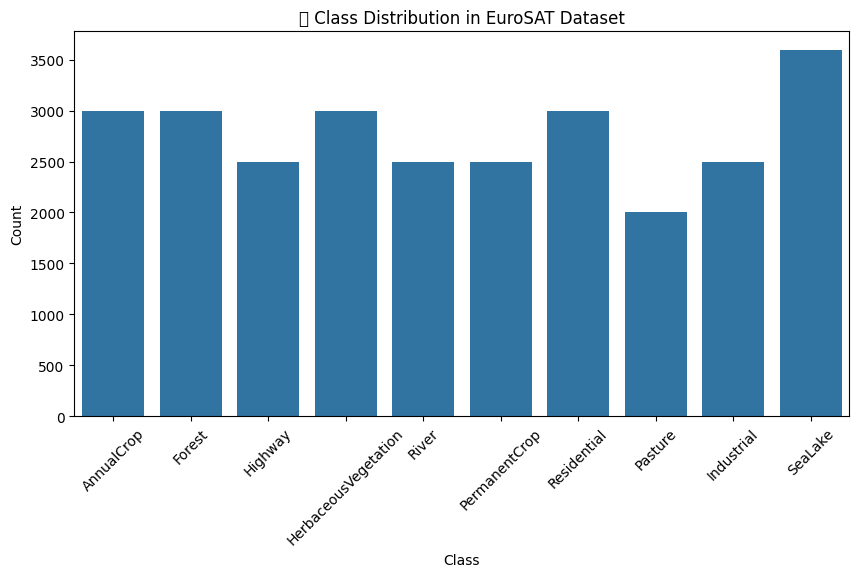

In [ ]:
data_dir = "eurosat_data/EuroSATallBands"

# Filter out files and keep only directories (the class folders)
class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print("Classes:", class_names)

# Count images per class
counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in class_names}
df_counts = pd.DataFrame(list(counts.items()), columns=["Class", "Count"])
print(df_counts)

plt.figure(figsize=(10,5))
sns.barplot(x="Class", y="Count", data=df_counts)
plt.xticks(rotation=45)
plt.title("🛰️ Class Distribution in EuroSAT Dataset")
plt.show()

In [ ]:
img_size = (64,64)   # EuroSAT default size

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Update the data_dir to point to the correct directory containing the images
data_dir = "eurosat_data/EuroSAT"

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    class_mode='categorical',
    subset="validation"
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(64,64,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(len(class_names), activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 685,386 (2.61 MB)

 Trainable params: 684,938 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
import os

data_dir = "eurosat_data/EuroSATallBands"

# List the contents of the main data directory
print(f"Contents of {data_dir}:")
print(os.listdir(data_dir))

# List the contents of a few class subdirectories as a sample
for class_name in class_names[:3]: # Check the first 3 classes
    class_dir = os.path.join(data_dir, class_name)
    print(f"\nContents of {class_dir} (first 10 files):")
    if os.path.exists(class_dir):
        print(os.listdir(class_dir)[:10])
    else:
        print("Directory not found.")

Contents of eurosat_data/EuroSATallBands:
['AnnualCrop', 'train.csv', 'Forest', 'validation.csv', 'Highway', 'HerbaceousVegetation', 'label_map.json', 'River', 'PermanentCrop', 'test.csv', 'Residential', 'Pasture', 'Industrial', 'SeaLake']

Contents of eurosat_data/EuroSATallBands/AnnualCrop (first 10 files):
[]

Contents of eurosat_data/EuroSATallBands/Forest (first 10 files):
[]

Contents of eurosat_data/EuroSATallBands/Highway (first 10 files):
[]


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


675/675 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.4953 - loss: 2.2709 - val_accuracy: 0.3524 - val_loss: 3.1010
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7255 - loss: 0.8028 - val_accuracy: 0.6431 - val_loss: 1.1783
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7600 - loss: 0.6982 - val_accuracy: 0.8115 - val_loss: 0.5717
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7994 - loss: 0.5919 - val_accuracy: 0.1969 - val_loss: 9.7944
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.8198 - loss: 0.5389 - val_accuracy: 0.7298 - val_loss: 0.9070
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.8461 - loss: 0.4517 - val_accuracy: 0.7120 - val_loss: 1.0548
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.8638 - loss: 0.3941 - val_accuracy: 0.7830 - val_loss: 0.7630
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.8864 - loss: 0.3482 - val_accurac

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


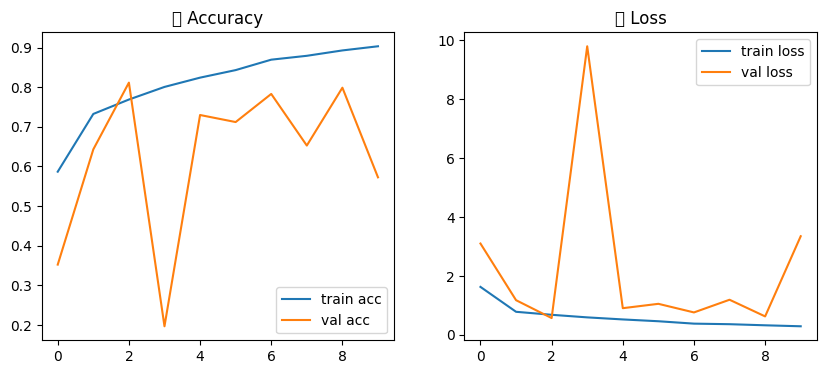

In [ ]:
# Accuracy & Loss curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend()
plt.title("📈 Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.title("📉 Loss")
plt.show()


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


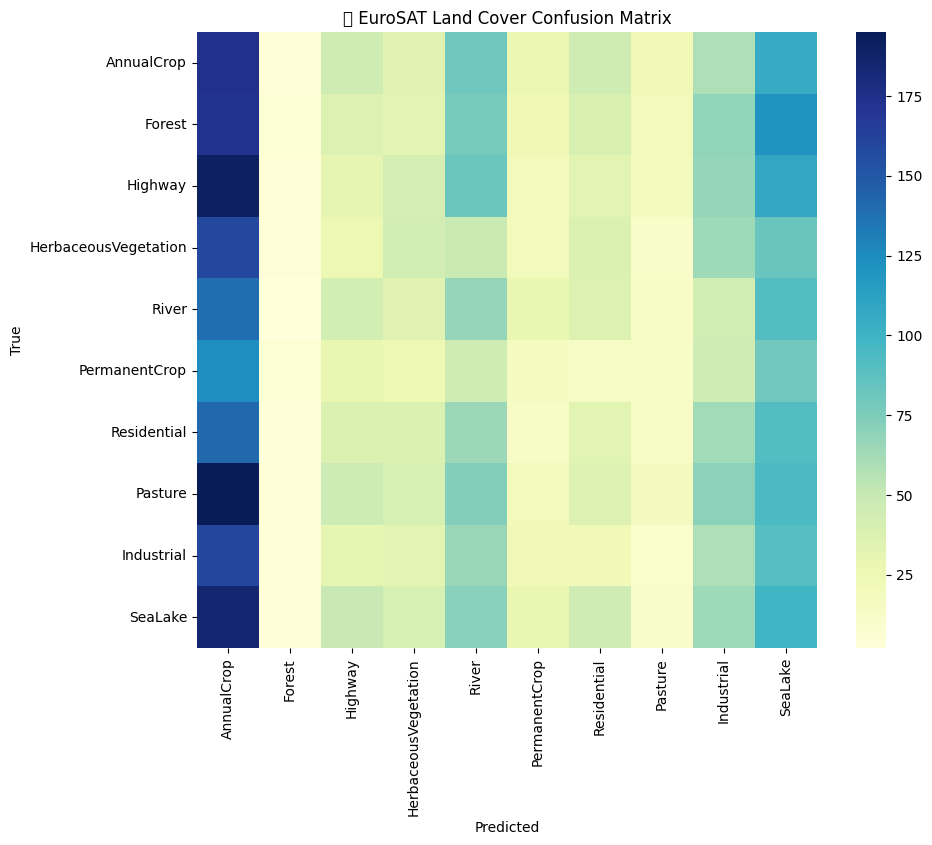

                      precision    recall  f1-score   support

          AnnualCrop       0.11      0.29      0.16       600
              Forest       0.14      0.01      0.02       600
             Highway       0.08      0.05      0.06       600
HerbaceousVegetation       0.12      0.09      0.10       500
               River       0.10      0.13      0.11       500
       PermanentCrop       0.08      0.04      0.05       400
         Residential       0.10      0.07      0.08       500
             Pasture       0.12      0.03      0.05       600
          Industrial       0.10      0.12      0.11       500
             SeaLake       0.10      0.17      0.13       600

            accuracy                           0.10      5400
           macro avg       0.10      0.10      0.09      5400
        weighted avg       0.10      0.10      0.09      5400



In [ ]:
# Predict on validation set
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(val_gen.classes, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)
plt.title("🌍 EuroSAT Land Cover Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(val_gen.classes, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


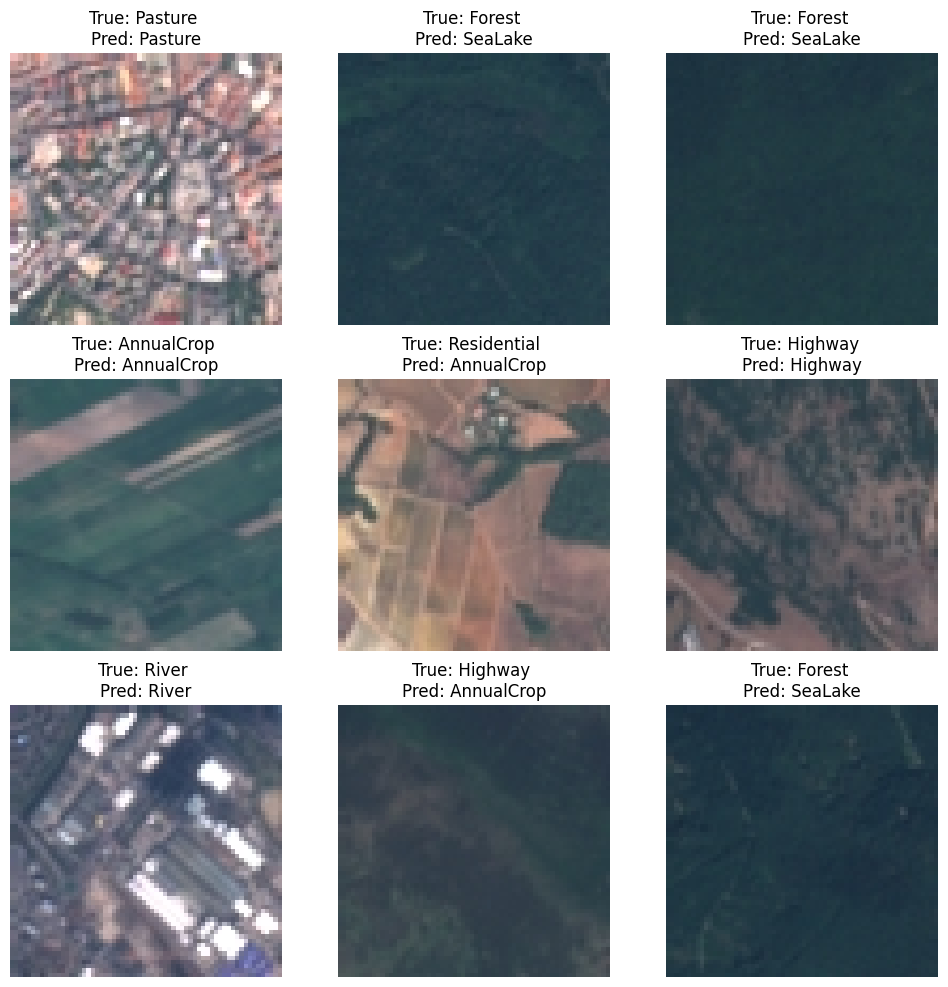

In [ ]:
x, y = next(val_gen)
preds = model.predict(x)
pred_labels = np.argmax(preds, axis=1)

plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x[i])
    plt.title(f"True: {class_names[np.argmax(y[i])]} \nPred: {class_names[pred_labels[i]]}")
    plt.axis("off")
plt.show()


In [ ]:
import matplotlib.colors as mcolors

# Assign fixed colors to classes
class_colors = {
    "AnnualCrop": "#e41a1c",
    "Forest": "#4daf4a",
    "HerbaceousVegetation": "#377eb8",
    "Highway": "#ff7f00",
    "Industrial": "#984ea3",
    "Pasture": "#ffff33",
    "PermanentCrop": "#a65628",
    "Residential": "#f781bf",
    "River": "#999999",
    "SeaLake": "#66c2a5"
}
cmap = mcolors.ListedColormap(list(class_colors.values()))


In [ ]:
x_batch, y_batch = next(val_gen)
preds = model.predict(x_batch)
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(y_batch, axis=1)

# Map predicted labels to class names
pred_classnames = [class_names[i] for i in pred_labels]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/tmp/ipython-input-47267029.py:21: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


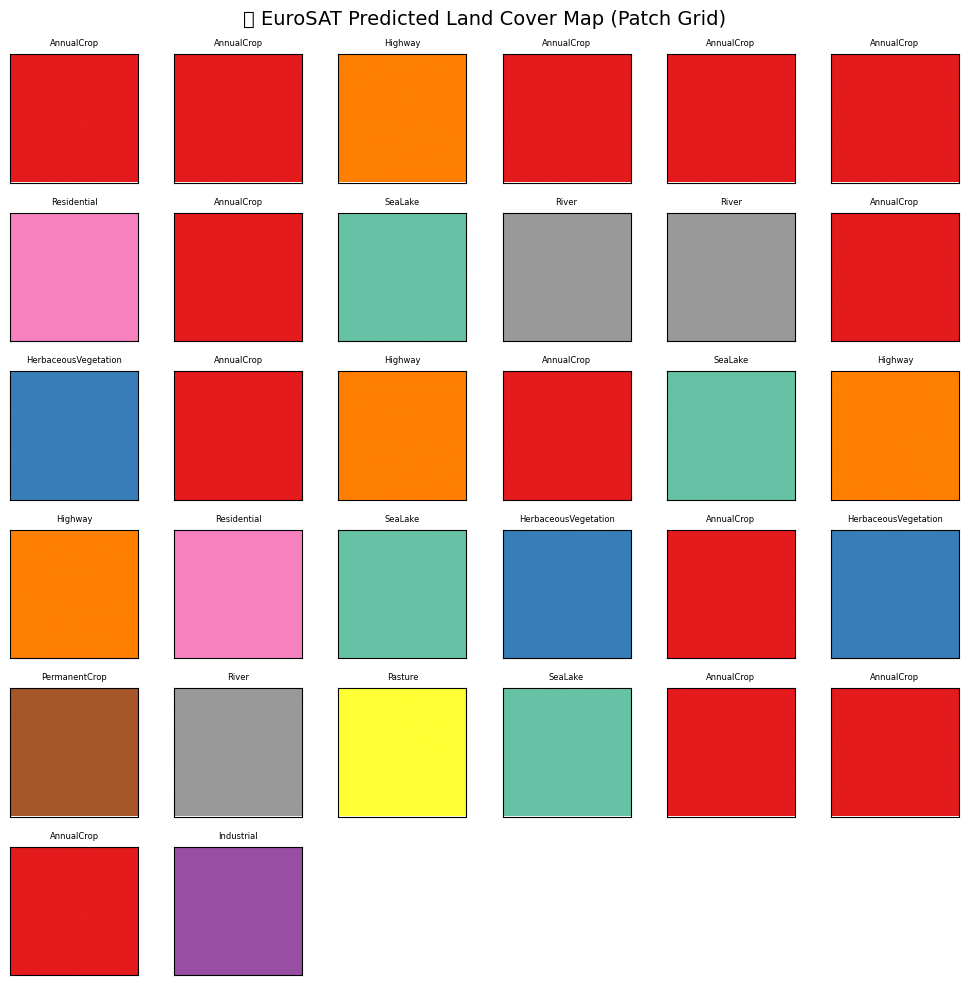

In [ ]:
grid_size = 6  # 6x6 = 36 patches
fig, ax = plt.subplots(grid_size, grid_size, figsize=(10,10))

# Adjust the loop to iterate only up to the actual batch size
for i in range(len(pred_classnames)):
    row, col = divmod(i, grid_size)
    # fill patch with predicted class color
    color = class_colors[pred_classnames[i]]
    ax[row, col].imshow(np.ones((64,64,3)) * mcolors.to_rgb(color))
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
    ax[row, col].set_title(pred_classnames[i], fontsize=6)

# Hide any unused subplots if the batch size is less than grid_size*grid_size
for i in range(len(pred_classnames), grid_size*grid_size):
    row, col = divmod(i, grid_size)
    fig.delaxes(ax[row, col])


plt.suptitle("🛰️ EuroSAT Predicted Land Cover Map (Patch Grid)", fontsize=14)
plt.tight_layout()
plt.show()

/tmp/ipython-input-289086918.py:16: UserWarning: Glyph 127806 (\N{EAR OF RICE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127806 (\N{EAR OF RICE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


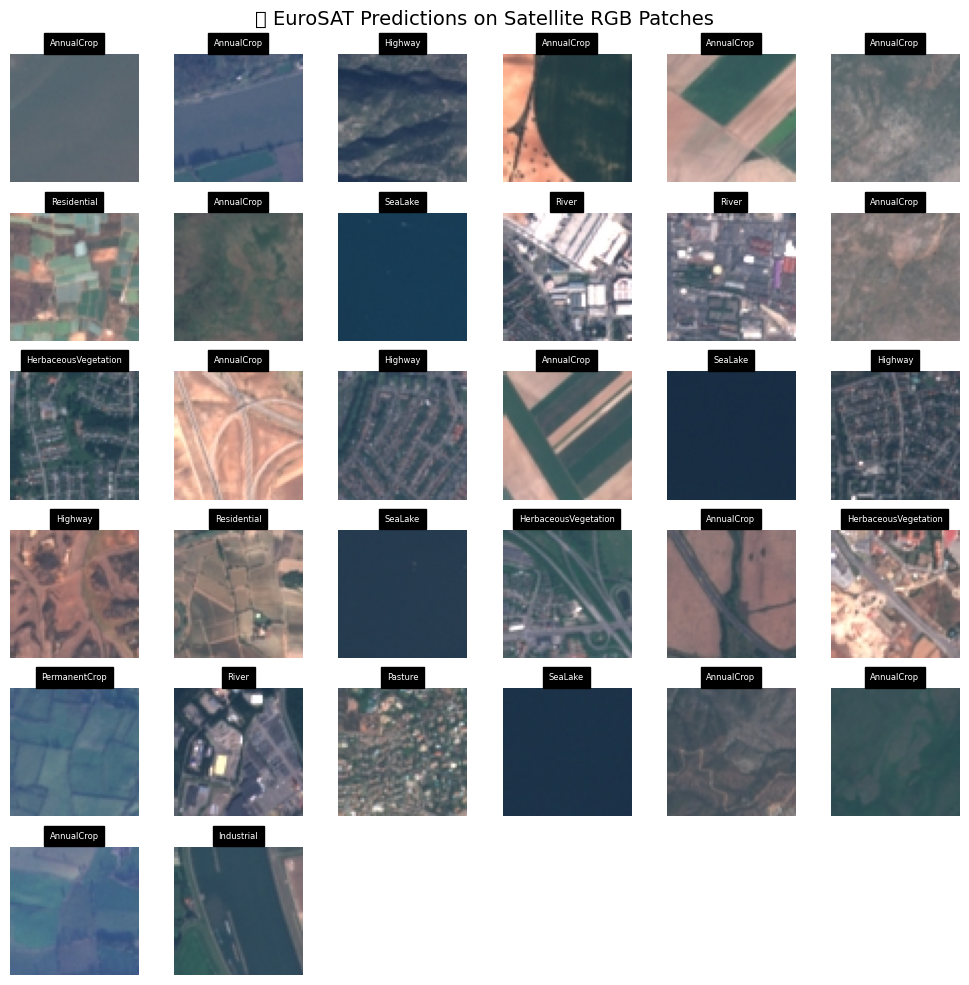

In [ ]:
fig, ax = plt.subplots(grid_size, grid_size, figsize=(10,10))

for i in range(len(x_batch)):
    row, col = divmod(i, grid_size)
    ax[row, col].imshow(x_batch[i])  # show real image
    ax[row, col].set_title(pred_classnames[i], fontsize=6, color="white", backgroundcolor="black")
    ax[row, col].axis("off")

# Hide any unused subplots if the batch size is less than grid_size*grid_size
for i in range(len(x_batch), grid_size*grid_size):
    row, col = divmod(i, grid_size)
    fig.delaxes(ax[row, col])


plt.suptitle("🌾 EuroSAT Predictions on Satellite RGB Patches", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# This comes from the data generator
class_indices = train_gen.class_indices
# Reverse mapping
idx_to_class = {v:k for k,v in class_indices.items()}

print("Class mapping:", idx_to_class)


Class mapping: {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


In [ ]:
import cv2
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

data_dir = "eurosat_data/EuroSAT" # Corrected data directory
img_size = (64,64)

features = []
labels = []

for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if os.path.isdir(cls_path):
        for file in tqdm(os.listdir(cls_path)[:200]):  # limit to 200 per class for speed
            img_path = os.path.join(cls_path, file)
            img = cv2.imread(img_path)  # BGR format
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Extract simple features (mean values per channel)
            mean_R = np.mean(img[:,:,0])
            mean_G = np.mean(img[:,:,1])
            mean_B = np.mean(img[:,:,2])

            features.append([mean_R, mean_G, mean_B])
            labels.append(cls)

df = pd.DataFrame(features, columns=["Mean_R","Mean_G","Mean_B"])
df["Label"] = labels
df.head()

100%|██████████| 200/200 [00:00<00:00, 1607.35it/s]


,Mean_R,Mean_G,Mean_B,Label
0,102.843750,97.620850,90.970703,AnnualCrop
1,145.822998,122.287842,118.740234,AnnualCrop
2,105.393799,99.010986,103.231445,AnnualCrop
3,146.305176,118.683105,102.410156,AnnualCrop
4,105.380127,105.651855,107.608154,AnnualCrop


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


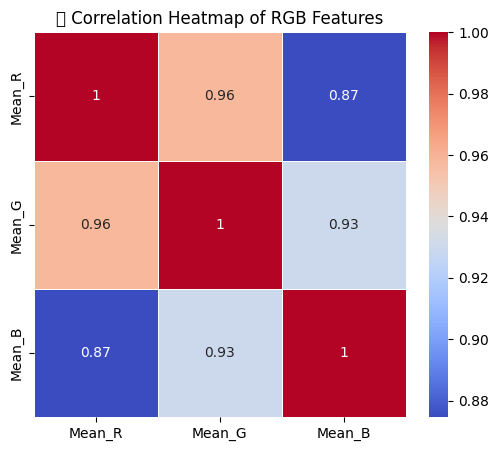

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.drop("Label", axis=1).corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("📊 Correlation Heatmap of RGB Features")
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


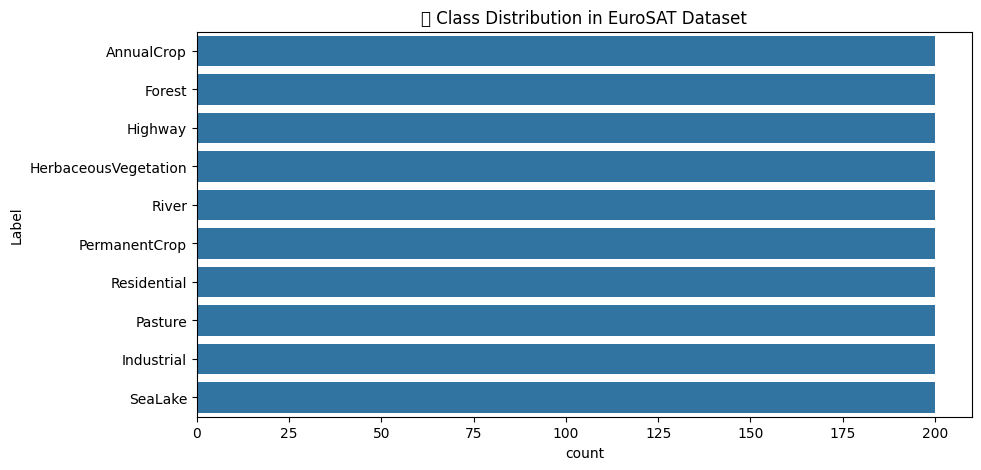

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(y="Label", data=df, order=df["Label"].value_counts().index)
plt.title("🛰️ Class Distribution in EuroSAT Dataset")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


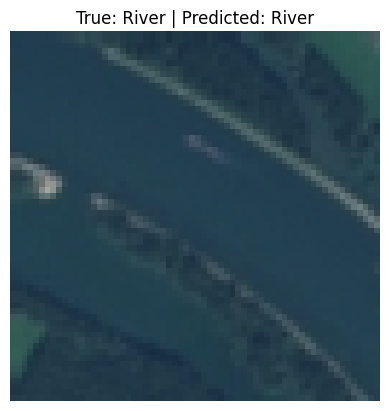

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Example: load a test image from validation generator
x_batch, y_batch = next(val_gen)
img = x_batch[0]  # first image

# Predict
pred = model.predict(img[np.newaxis, ...])  # shape (1,64,64,3)
pred_idx = np.argmax(pred)
pred_class = idx_to_class[pred_idx]

true_idx = np.argmax(y_batch[0])
true_class = idx_to_class[true_idx]

plt.imshow(img)
plt.axis("off")
plt.title(f"True: {true_class} | Predicted: {pred_class}")
plt.show()


In [ ]:
def predict_crop(img_path):
    # Load image
    img = image.load_img(img_path, target_size=(64,64))
    img_array = image.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_array)
    pred_idx = np.argmax(pred)
    pred_class = idx_to_class[pred_idx]

    return pred_class

# Example: Construct a correct path to a sample image
data_dir_corrected = "eurosat_data/EuroSAT"
# Get the first class name from the list
sample_class = class_names[0]
sample_class_dir = os.path.join(data_dir_corrected, sample_class)

# Find the first file in the sample class directory
img_file = None
if os.path.exists(sample_class_dir):
    files_in_class = os.listdir(sample_class_dir)
    if files_in_class:
        img_file = files_in_class[0]

if img_file:
    img_path = os.path.join(sample_class_dir, img_file)
    print(f"Using image path: {img_path}")
    print("Predicted Crop:", predict_crop(img_path))
else:
    print(f"No image files found in {sample_class_dir}")

Using image path: eurosat_data/EuroSAT/AnnualCrop/AnnualCrop_2386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Crop: AnnualCrop
